In [1]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import cv2 as cv
import numpy as np
from PIL import Image
from yolo import YOLO
from matplotlib import pyplot as plt
import json
import pdb

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet

%matplotlib inline
warnings.filterwarnings('ignore')

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cam_id = 'AB03'
start_time = 0

In [3]:
# Definition of the parameters
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0

# deep_sort 
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [4]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


In [5]:
outputing_video = True 

cap_name = './CAG/afternoon 1300/AB03-1300H.avi'
#cap_name = './CAG/morning 0830/AB07-0830H (1).avi'
#cap_name = './CAG/afternoon 1300/AB04-1300H.avi'
#cap_name = './CAG/midnight 0200/AB07-0200H.avi'
#cap_name = './CAG/rainy conditions/AB07-1600H.avi'

vcap = cv.VideoCapture(cap_name)
#vcap = cv.VideoCapture('./CAG/afternoon 1300/AB04-1300H.avi')
#vcap = cv.VideoCapture('./CAG/midnight 0200/AB07-0200H.avi')
#vcap = cv.VideoCapture('./CAG/rainy conditions/AB07-1600H.avi')

img_w = int(vcap.get(3))
img_h = int(vcap.get(4))
fps = vcap.get(cv.CAP_PROP_FPS)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, fps, (img_w, img_h))

# lane area extremes
roi = [[0, 365], [0, 575], [767, 575], [767, 498], [438, 170], [241, 170], [0, 365]] # afternoon/AB03-1300H
#roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # morning/AB07-1600H
#roi = [[0, 400], [0, 575], [767, 575], [470, 130], [320, 130], [0, 400]] # afternoon/AB04-1300H
#roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # rainy/AB07-1600H
#roi = [[250, 575], [767, 575], [767, 390], [260, 110], [160, 110], [250, 575]] # night/AB07-0200H

# lane sections info
sec_length = 4.4 * 3 # in metres (avg car len 4.4 * numbers of cars can fit into section) # afternoon/AB03-1300H
sections = [575, 352, 268, 225, 170] # afternoon/AB03-1300H 

In [6]:
track_encoder = lambda track: {"vechicle_id": track.track_id,
                               "classs": int(track.detection.cls),
                               "conf": track.detection.score,
                               "speed": track.speed if hasattr(track, 'speed') else 0,
                               "xmin": track.to_tlwh().tolist()[0],
                               "ymin": track.to_tlwh().tolist()[1],
                               "xmax": track.to_tlwh().tolist()[0] + track.to_tlwh().tolist()[2],
                               "ymax": track.to_tlwh().tolist()[1] + track.to_tlwh().tolist()[3]}

jfile = 'output.json'
samples_per_sec = 4 # no. of outputs per second
speed_frames = 10 # no. of frames speed is calc. against. e.g. if 5, speed is calculated based on last 5 frames

In [7]:
def add_cv_drawing(frame, detections, tracker, avg_spd, occupancy):
    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update > 1 :
            continue
        bbox = track.to_tlbr()
        cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 1)
        cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])-3),0, 5e-3 * 100, (0,255,0), 1)
        
    for det in detections:
        bbox = det.to_tlbr()
        cv.rectangle(frame,(int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,0,0), 1)
        cv.putText(frame, 
                   ' ' + yolo.class_names[det.cls] + ' ' + str(det.score),
                   (int(bbox[0])+3, int(bbox[1])-3), 0, 5e-3 * 100, (0,255,0),1)
    
    cv.putText(frame, 'detections: %d' % len(detections), (5, img_h-48), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'avergate speed: %.2f' % avg_spd, (5, img_h-28), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'occupancy: %.2f' % occupancy, (5, img_h-8), 0, 5e-3 * 150, (0,255,0), 1)

In [8]:
def calc_dist_travelled(ends):
    y1, y2 = ends
    dist = 0
    for idx, s in enumerate(sections[:-1]):
        if idx == 0:
            continue

        if y1 >= s:
            dist += (y1 - s) / (sections[idx - 1] - s) * sec_length
            #print('y1: {} {} {} {}'.format(y1, s, (y1 - s) / (sections[idx - 1] - s) * sec_length, dist))
            y1 = s
            
        if s >= y2 >= sections[idx + 1]:
            dist += (y1 - y2) / (s - sections[idx + 1]) * sec_length
            #print('y2: {} {} {} {}'.format(y2, s, (y1 - y2) / (s - sections[idx + 1]) * sec_length, dist))
            break
            
    return abs(dist)

In [9]:
def average_track_speed(tracker, fps, frame_idx):
    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update > 1 :
            if hasattr(track, 'speed'):
                delattr(track, 'speed')
            continue
            
        # update track speed in y direction, in pixels/seconds
        if not hasattr(track, 'hist_frames'):
            track.hist_frames = []
            track.hist_bboxes = []
        track.hist_frames.append(frame_idx)
        track.hist_bboxes.append(track.to_tlwh())

        if len(track.hist_frames) > speed_frames:
            cur_bbox = track.to_tlwh()
            cur_c_y = (cur_bbox[1] + cur_bbox[3] /2)
            first_bbox = track.hist_bboxes[-speed_frames]
            first_c_y = first_bbox[1] + first_bbox[3] /2
            track.ends = (first_c_y, cur_c_y)

            dist_travelled = calc_dist_travelled(track.ends)
            life = frame_idx - track.hist_frames[-speed_frames]
            speed = dist_travelled / life * fps * 3.6 # km/hr
            
            track.speed = speed
            #pdb.set_trace()
    
    track_speeds = [track.speed for track in tracker.tracks if hasattr(track, 'speed')]
    avg_spd = np.sum(track_speeds) / len(track_speeds)
    
    return avg_spd

In [10]:
frame_idx = 0

In [11]:
proc_fps = 0.0
output_data = []

while True:
    ret, frame = vcap.read()  # frame shape 640*480*3
    if ret != True:
        break;
    t1 = time.time()

    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image) # x,y,w,h, score, class
    
    # separate out score, class info from loc
    scores_classes = [box[-2:] for box in boxs]
    boxs = [box[0:4] for box in boxs]
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]
        
    # filter unwanted obj by classfication
    for idx, det in list(enumerate(detections)):
        det.score = "%.2f" % scores_classes[idx][0]
        det.cls = scores_classes[idx][1]
    detections = [det for det in detections if yolo.class_names[det.cls] in ['person', 'bicycle', 'car',
                                                                             'motorbike', 'aeroplane',
                                                                             'bus', 'train', 'truck']]
    
    # filter detections with roi
    detections = [det for det in detections if 0 < cv.pointPolygonTest(np.array(roi),
                                                                       (det.to_xyah()[0], det.to_xyah()[1]),
                                                                       False)]
    
    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)
        
    # Add aggregated data
    avg_spd = average_track_speed(tracker, fps, frame_idx)
    lane_area = cv.contourArea(np.array(roi))
    box_area = np.sum([det.tlwh[2] * det.tlwh[3] for det in detections])
    occupancy = box_area / lane_area
    
    if outputing_video:
        add_cv_drawing(frame, detections, tracker, avg_spd, occupancy)
        out.write(frame)
    
    frame_idx += 1

    proc_fps  = ( proc_fps + (1./(time.time()-t1)) ) / 2
    #print("fps= %f"%(proc_fps))
    
    print('{}: tracking {} vehicles, with average speed at {:.1f} km/h. {:.2f}% of the road surface is occupied.'.format(frame_idx, len(tracker.tracks), avg_spd, occupancy*100))  
    for t in tracker.tracks:
        if hasattr(t, 'speed'):
            print('{}: {} {}'.format(t.track_id, t.speed, t.ends))
    cv.imwrite('./CAG/test/AB03_' + str(frame_idx) + '.jpg', frame)
    
    output_data.append({
        "data_event_name": "vehicle_detection",
        "camera_id": cam_id,
        "lane_id": 1,
        "frame_idx": frame_idx,
        "average_speed": avg_spd,
        "lane_occupancy": occupancy,
        "time_stamp": float(start_time) + frame_idx / fps,
        "vehicles": [track_encoder(trk) for trk in tracker.tracks]
    })
    
    if frame_idx >= 250:
        break

1: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
2: tracking 1 vehicles, with average speed at nan km/h. 1.09% of the road surface is occupied.
3: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
4: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
5: tracking 1 vehicles, with average speed at nan km/h. 1.01% of the road surface is occupied.
6: tracking 1 vehicles, with average speed at nan km/h. 0.93% of the road surface is occupied.
7: tracking 1 vehicles, with average speed at nan km/h. 0.93% of the road surface is occupied.
8: tracking 1 vehicles, with average speed at nan km/h. 0.89% of the road surface is occupied.
9: tracking 1 vehicles, with average speed at nan km/h. 1.03% of the road surface is occupied.
10: tracking 1 vehicles, with average speed at nan km/h. 1.01% of the road surface is occupied.
11: tracking 1 vehicles, with average speed at na

71: tracking 3 vehicles, with average speed at nan km/h. 1.42% of the road surface is occupied.
72: tracking 2 vehicles, with average speed at 71.3 km/h. 1.01% of the road surface is occupied.
8: 71.25519874731044 (338.76446280991735, 293.41990534363487)
73: tracking 2 vehicles, with average speed at 68.2 km/h. 1.12% of the road surface is occupied.
8: 68.209164670584 (333.7347075873227, 290.32854998048333)
74: tracking 2 vehicles, with average speed at 69.6 km/h. 1.05% of the road surface is occupied.
8: 69.57579301511848 (329.22644047729966, 284.95060376503034)
75: tracking 2 vehicles, with average speed at 67.6 km/h. 0.95% of the road surface is occupied.
8: 67.63417758482746 (324.16756081987296, 281.1273068300443)
76: tracking 2 vehicles, with average speed at 60.5 km/h. 0.91% of the road surface is occupied.
8: 60.54129080735948 (317.12490363910615, 278.5983387237167)
77: tracking 2 vehicles, with average speed at 59.8 km/h. 1.01% of the road surface is occupied.
8: 59.80089199632

135: tracking 2 vehicles, with average speed at nan km/h. 2.77% of the road surface is occupied.
136: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
137: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
138: tracking 2 vehicles, with average speed at nan km/h. 1.57% of the road surface is occupied.
139: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
140: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
141: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
142: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
143: tracking 1 vehicles, with average speed at nan km/h. 2.04% of the road surface is occupied.
144: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
145: tracking 0 vehicles, with

220: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
221: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
222: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
223: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
224: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
225: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
226: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
227: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
228: tracking 1 vehicles, with average speed at nan km/h. 2.01% of the road surface is occupied.
229: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
230: tracking 0 vehicles, with

In [12]:
with open(jfile, 'w') as jout:
    json.dump(output_data, jout)

In [13]:
vcap.release()
out.release()

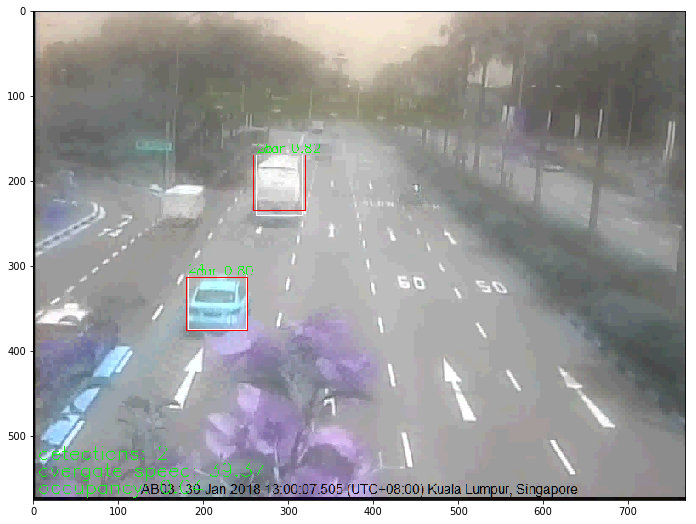

In [14]:
plt.figure(figsize=(16, 9))
plt.imshow(frame)

In [13]:
cv.imwrite('./CAG/test/AB03.jpg', frame)

True